In [254]:
from tracr.rasp import rasp
from tracr.compiler import compiling
from tracr.compiler import lib

import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\src")

from Model import Model
from functions import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [255]:
from tracr.rasp import rasp

def make_sort_unique(vals: rasp.SOp, keys: rasp.SOp) -> rasp.SOp:
  """Returns vals sorted by < relation on keys.

  Only supports unique keys.

  Example usage:
    sort = make_sort(rasp.tokens, rasp.tokens)
    sort([2, 4, 3, 1])
    >> [1, 2, 3, 4]

  Args:
    vals: Values to sort.
    keys: Keys for sorting.
  """
  smaller = rasp.Select(keys, keys, rasp.Comparison.LT).named("smaller")
  target_pos = rasp.SelectorWidth(smaller).named("target_pos")
  sel_new = rasp.Select(target_pos, rasp.indices, rasp.Comparison.EQ)
  return rasp.Aggregate(sel_new, vals).named("sort")


def make_sort(vals: rasp.SOp, keys: rasp.SOp, *, max_seq_len: int,
              min_key: float) -> rasp.SOp:
  """Returns vals sorted by < relation on keys, which don't need to be unique.

  The implementation differs from the RASP paper, as it avoids using
  compositions of selectors to break ties. Instead, it uses the arguments
  max_seq_len and min_key to ensure the keys are unique.

  Note that this approach only works for numerical keys.

  Example usage:
    sort = make_sort(rasp.tokens, rasp.tokens, 5, 1)
    sort([2, 4, 3, 1])
    >> [1, 2, 3, 4]
    sort([2, 4, 1, 2])
    >> [1, 2, 2, 4]

  Args:
    vals: Values to sort.
    keys: Keys for sorting.
    max_seq_len: Maximum sequence length (used to ensure keys are unique)
    min_key: Minimum key value (used to ensure keys are unique)

  Returns:
    Output SOp of sort program.
  """
  keys = rasp.SequenceMap(lambda x, i: x + min_key * i / max_seq_len, keys,
                          rasp.indices)
  return make_sort_unique(vals, keys)


In [256]:
from tracr.rasp import rasp

def make_sort_unique_buggy(vals: rasp.SOp, keys: rasp.SOp) -> rasp.SOp:
  """Returns vals sorted by < relation on keys.

  Only supports unique keys.

  Example usage:
    sort = make_sort(rasp.tokens, rasp.tokens)
    sort([2, 4, 3, 1])
    >> [1, 2, 3, 4]

  Args:
    vals: Values to sort.
    keys: Keys for sorting.
  """
  # BUG: GT instead of LT, resulting in descending order instead of ascending
  smaller = rasp.Select(keys, keys, rasp.Comparison.GT).named("smaller")
  target_pos = rasp.SelectorWidth(smaller).named("target_pos")
  sel_new = rasp.Select(target_pos, rasp.indices, rasp.Comparison.EQ)
  return rasp.Aggregate(sel_new, vals).named("sort")


def make_sort_buggy(vals: rasp.SOp, keys: rasp.SOp, *, max_seq_len: int,
              min_key: float) -> rasp.SOp:
  """Returns vals sorted by < relation on keys, which don't need to be unique.

  The implementation differs from the RASP paper, as it avoids using
  compositions of selectors to break ties. Instead, it uses the arguments
  max_seq_len and min_key to ensure the keys are unique.

  Note that this approach only works for numerical keys.

  Example usage:
    sort = make_sort(rasp.tokens, rasp.tokens, 5, 1)
    sort([2, 4, 3, 1])
    >> [1, 2, 3, 4]
    sort([2, 4, 1, 2])
    >> [1, 2, 2, 4]

  Args:
    vals: Values to sort.
    keys: Keys for sorting.
    max_seq_len: Maximum sequence length (used to ensure keys are unique)
    min_key: Minimum key value (used to ensure keys are unique)

  Returns:
    Output SOp of sort program.
  """
  keys = rasp.SequenceMap(lambda x, i: x + min_key * i / max_seq_len, keys,
                          rasp.indices)
  return make_sort_unique_buggy(vals, keys)

In [257]:
from tracr.compiler import compiling

max_seq_len=5
sort = make_sort(rasp.tokens, rasp.tokens, max_seq_len=max_seq_len, min_key=1)
bos = "BOS"

classModel = Model(sort, inputs={10, 20, 30, 40, 50}, seqLength=max_seq_len, name="sort model")

print(classModel.model.model_config)

max_seq_len=5
buggy_sort = make_sort_buggy(rasp.tokens, rasp.tokens, max_seq_len=max_seq_len, min_key=1)
bos = "BOS"

classModelBuggy = Model(buggy_sort, inputs={10, 20, 30, 40, 50}, seqLength=max_seq_len, name="buggy sort model")

print(classModelBuggy.model.model_config)

TransformerConfig(num_heads=1, num_layers=3, key_size=27, mlp_hidden_size=25, dropout_rate=0.0, activation_function=<jax._src.custom_derivatives.custom_jvp object at 0x0000020B54E90260>, layer_norm=False, causal=False)
TransformerConfig(num_heads=1, num_layers=3, key_size=27, mlp_hidden_size=25, dropout_rate=0.0, activation_function=<jax._src.custom_derivatives.custom_jvp object at 0x0000020B54E90260>, layer_norm=False, causal=False)


In [258]:
import numpy as np
np.random.seed(666) #Seed for consistency
import jax

acceptedTokens = [10, 20, 30, 40, 50]
maxSeqLength = max_seq_len
size = 1000
X = []
Y = []

for i in range(size):
    # TODO: implement padding for training
    # inputLength = np.random.randint(2, maxSeqLength+1)  #Uniformly distributed between 2 and max length
    inputLength = maxSeqLength

    inputSeq = []
    outputSeq = []
    for t in np.random.choice(acceptedTokens, inputLength):
        inputSeq.append(t)
        outputSeq.append(t)

    inputSeq.insert(0, bos)
    outputSeq.sort()
    outputSeq.insert(0, 10) # The output_encoder does has a None bos_encoding, so we use the input_encoder's

    inputSeq = jax.numpy.array(classModel.model.input_encoder.encode(inputSeq))
    outputSeq = jax.numpy.array(classModel.model.output_encoder.encode(outputSeq))

    X.append(inputSeq)
    Y.append(outputSeq)

X = jax.numpy.array(X)
Y = jax.numpy.array(Y)

X, Y
print(X.shape)

# Remove duplicates from X, and the corresponding Y
X, indices = np.unique(X, return_index=True, axis=0)
Y = Y[indices]
print(X.shape)

#NOTE Added shuffling of the data as np.unique sorts by default
randind = np.arange(X.shape[0])
np.random.shuffle(randind)
X = X[randind]
Y = Y[randind]

# Split test and validation
split = int(X.shape[0] * 0.90)
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]
print(X_train.shape, X_test.shape)

(1000, 6)
(869, 6)
(782, 6) (87, 6)


In [259]:
print("Encoding map:")
print(classModel.model.input_encoder.encoding_map)
print(classModel.model.output_encoder.encoding_map)

print("Example input and output:")
print(X_train[0])          
print(Y_train[0])            
print(X_test[0])
print(Y_test[0])

#Temp padded test
padIn = X_train[0]
padIn[5]=6
padIn[4]=6
print("padIn", padIn)
paddedOutput = classModel.forward(jax.numpy.array([padIn]))
print("padIn",paddedOutput.unembedded_output.argmax(axis=-1)[0])
X_train[0][5]=0
X_train[0][4]=2

fakeIn = jax.numpy.array([5,3,1,2,6,6])
print("fakeIn", fakeIn)
fakeOutput = classModel.forward(jax.numpy.array([fakeIn]))
print("fakeOut",fakeOutput.unembedded_output.argmax(axis=-1)[0])

#NOTE is there a bug that the input requires a 0 encoding for it to be correct?
#The loss should ignore the first token so if the rest is ok it should be ok
#The first token seem to be nonsense from a precursory view meaning it should be fine since the loss ignores it

#On further research it is not fine the input (bos, 3,1,2,pad,pad) gives output (1,1,2,3,1,1) which is not correctly sorted
#nor correctly padded

#If it is a case of shifting the results however many segments it has been padded with we could potentially solve it in the 
#loss function by looking at how much the input is padded and ignore that from the output

#Ideally the collator should apply to the maximum length in the batch and not the maximum sequence length 
# (Fuck this we never use large sequences anyways and most batches will have at least one sample of max length)

#There are two problem with this method
    #1. I don't know if this is applied equally for all the different models we try
    #2. I would need to see that all the model inputs follow this pattern

print("Example forward pass:")
print(X_train.shape)
temp = jax.numpy.array([X_train[0]])
print(temp, temp.shape)
output = classModel.forward(jax.numpy.array([X_train[0]]))
print(output.unembedded_output)
print(output.unembedded_output.argmax(axis=-1)[0])

print("Example forward pass with model wrapper:")
print(classModel.apply([bos, 40, 50, 20, 30, 40]))

Encoding map:
{10: 0, 20: 1, 30: 2, 40: 3, 50: 4, 'BOS': 5, 'compiler_pad': 6}
{10: 0, 20: 1, 30: 2, 40: 3, 50: 4}
Example input and output:
[5 3 1 0 2 0]
[0 0 0 1 2 3]
[5 0 4 0 0 3]
[0 0 0 0 3 4]
padIn [5 3 1 0 6 6]
padIn [0 0 1 3 0 0]
fakeIn [5 3 1 2 6 6]
fakeOut [1 1 2 3 1 1]
Example forward pass:
(782, 6)
[[5 3 1 0 2 0]] (1, 6)
[[[1.32399279e-04 6.61996396e-05 6.61996396e-05 6.61996396e-05
   0.00000000e+00]
  [9.99933770e-01 4.38500439e-09 4.38500439e-09 4.38500439e-09
   0.00000000e+00]
  [9.99933770e-01 4.38500439e-09 4.38500439e-09 4.38500439e-09
   0.00000000e+00]
  [8.77000878e-09 9.99933765e-01 4.38500439e-09 4.38500439e-09
   0.00000000e+00]
  [8.77000878e-09 4.38500439e-09 9.99933765e-01 4.38500439e-09
   0.00000000e+00]
  [8.77000878e-09 4.38500439e-09 4.38500439e-09 9.99933765e-01
   0.00000000e+00]]]
[0 0 0 1 2 3]
Example forward pass with model wrapper:
['BOS', 20, 30, 40, 40, 50]


In [260]:
maxLength = 5
inputs = {1,2,3,4,5,6}

sortFunction = lib.make_sort(rasp.tokens, rasp.tokens, max_seq_len=maxLength, min_key=min(inputs))

data = generateData("sort", maxLength, 1000)

X, Y = encodeAndPadData(data, sortFunction, inputs, maxLength)

In [282]:
maxLength = 5
name = "sort"

model = generateModel(name, maxLength)

data = generateData(name, maxLength, 1000)
split = int(len(data) * 0.90)
data_train, data_test = data[:split], data[split:]
split = int(len(data_train) * 0.85)
data_train, data_val = data_train[:split], data_train[split:]
X, Y = encodeAndPadData(data, model.raspFunction, model.inputs, maxLength)

#Split data
split = int(X.shape[0] * 0.90)
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]

split = int(X_train.shape[0] * 0.85)
X_train, X_val = X_train[:split], X_train[split:]
Y_train, Y_val = Y_train[:split], Y_train[split:]

print(X_train[:5])
print(Y_train[:5])

print(X_train.shape, X_val.shape, X_test.shape)
print(Y_train.shape, Y_val.shape, Y_test.shape)
print(len(data_train), len(data_val), len(data_test))

[[6 4 3 4 4 0]
 [6 3 0 0 2 1]
 [6 3 0 7 7 7]
 [6 5 0 0 7 7]
 [6 0 1 7 7 7]]
[[0 0 3 4 4 4]
 [0 0 0 1 2 3]
 [0 0 3 0 0 0]
 [0 0 0 5 0 0]
 [0 0 1 0 0 0]]
(765, 6) (135, 6) (100, 6)
(765, 6) (135, 6) (100, 6)
765 135 100


Evaluating model: Random weights
1.0
Evaluating model: Non-encoded random weights
1.0


  5%|▌         | 251/5000 [00:53<16:54,  4.68it/s]

Stopped training after 251 epochs by early stopping


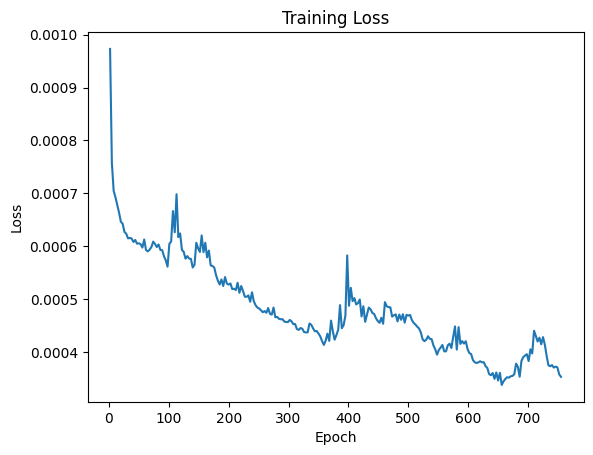

Evaluating model: Trained
0.83
Evaluating model: Non-encoded trained
0.753


In [284]:
#model.setRandomWeights()
model.resetWeights()


print(model.evaluateEncoded(X_test, Y_test, "Random weights", outputArray=False))
print(model.evaluateModel(data_test, "Non-encoded random weights", outputArray=False))
model.train(X_train, Y_train, 5000, 256, 1e-4, True, X_val = X_val, Y_val = Y_val, valCount = 5)
temp3 = model.evaluateEncoded(X_test, Y_test, "Trained")
print(np.mean(temp3))
temp4 = model.evaluateModel(data_test, "Non-encoded trained")
print(np.mean(temp4))

#Reverse (Surprising), most-freq, shuffle_dyck1 and shuffle_dyck2 often doesn't work with random parameters

#The evaluate forward pass seems to work though which is kinda wierd. (it might be that the encoding works since it is not jitted)

#Oddly the logits for reverse is not all nans
#   When I ran it again with different initialization they were

#Look into if the problem is due to the initial values being to large (Doesn't seem like it)

#Since the problem doesn't happen when training correct models it might be a problem of some over/undeflow caused by the initial values

#Currently training a perfect model will often cause the model to perform worse

#The encoded and unencoded evaluation does not give the same result.
#Further testing suggests that the problem is that the output of the training model and the rasp model is not consistent
#The problem is that the model output is not the same as the training output fairly often

In [ ]:
data = generateData("sort", 5, 1000)
X, Y = generateAndEncodeData("sort", 5, 1000)
print(data[0])
print(X[0])

(['BOS', np.int64(3), np.int64(6), np.int64(1), np.int64(1), np.int64(5)], ['BOS', np.int64(1), np.int64(1), np.int64(3), np.int64(5), np.int64(6)])
[6 1 1 1 0 0]


In [ ]:
for i in range(3):
    print(data[i])
    print(model.apply(data[i][0]))
    print(X[i],Y[i],"\n#######")
"""offset=90
print(temp3[offset:offset+15])
print(temp4[offset:offset+15])"""
print("Encoded true unencoded false")
target = 16 #Encoded true unencoded false
#print(temp3[target], temp4[target])
print(data[target])
print(model.apply(data[target][0]))
print(X[target],Y[target])
#print(X[target])
#print(model.forward(jnp.array(X[target])))      
print(model.forward(jnp.array(X[target])).unembedded_output.argmax(axis=-1)[0])      
#My training data does not seem to have the same structure as his training data. The shapes are the same but when indexing his you get (1, len) not (len,)
#Might be due to creating a jnp array from numpy encoded variables instead of raw variables
target = 177#Opposite
#print(temp3[target], temp4[target])
print("Encoded false unencoded true")
print(data[target])
print(model.apply(data[target][0]))
print(X[target],Y[target])
#print(model.forward(X[target]))
print(model.forward(X[target:target+1]).unembedded_output.argmax(axis=-1)[0])  

(['BOS', np.int64(3), np.int64(6), np.int64(1), np.int64(1), np.int64(5)], ['BOS', np.int64(1), np.int64(1), np.int64(3), np.int64(5), np.int64(6)])
['BOS', 1, 6, 4, 5, 1]
[6 1 1 1 0 0] [0 0 0 1 1 1] 
#######
(['BOS', np.int64(4), np.int64(6), np.int64(3)], ['BOS', np.int64(3), np.int64(4), np.int64(6)])
['BOS', 6, 4, 3]
[6 0 2 0 7 7] [0 0 0 2 0 0] 
#######
(['BOS', np.int64(4), np.int64(2), np.int64(1), np.int64(2), np.int64(1)], ['BOS', np.int64(1), np.int64(1), np.int64(2), np.int64(2), np.int64(4)])
['BOS', 5, 2, 3, 2, 3]
[6 4 0 7 7 7] [0 0 4 0 0 0] 
#######
Encoded true unencoded false
(['BOS', np.int64(6), np.int64(1), np.int64(5)], ['BOS', np.int64(1), np.int64(5), np.int64(6)])
['BOS', 1, 1, 4]
[6 5 5 5 2 7] [0 2 5 5 5 0]


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
temp3 = np.mean(model.evaluateEncoded(X, Y, "Trained"))
temp4 = np.mean(model.evaluateModel(data, "Non encoded"))
print(temp3)
print(temp4)

In [ ]:
print("Correct model: ", np.mean(classModel.evaluateEncoded(X_test, Y_test)))
classModelBuggy.resetWeights()
print("Buggy model: ", np.mean(classModelBuggy.evaluateEncoded(X_test, Y_test)))

Evaluating model: sort model
Correct model:  1.0
Evaluating model: buggy sort model
Buggy model:  0.0


100%|██████████| 15000/15000 [18:53<00:00, 13.23it/s] 


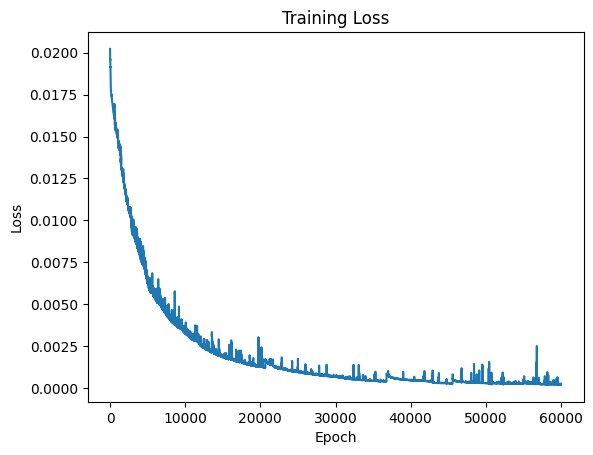

In [203]:
classModelBuggy.resetWeights()
_ = classModelBuggy.train(X_train, Y_train, n_epochs=15000, batch_size=256, lr=1e-5, plot=True)

In [202]:
print("Buggy model: ", np.mean(classModelBuggy.evaluateEncoded(X_test, Y_test)))

Evaluating model: buggy sort model
Buggy model:  0.06896551724137931


In [54]:
#Sets random normaly distributed weights
classModelRandom = Model(sort, inputs={10, 20, 30, 40, 50}, seqLength=max_seq_len, name="random model")

classModelRandom.setRandomWeights()

In [55]:
print("Random model: ", np.mean(classModelRandom.evaluateEncoded(X_test, Y_test)))

Evaluating model: random model
Random model:  0.0


100%|██████████| 5000/5000 [06:25<00:00, 12.96it/s]


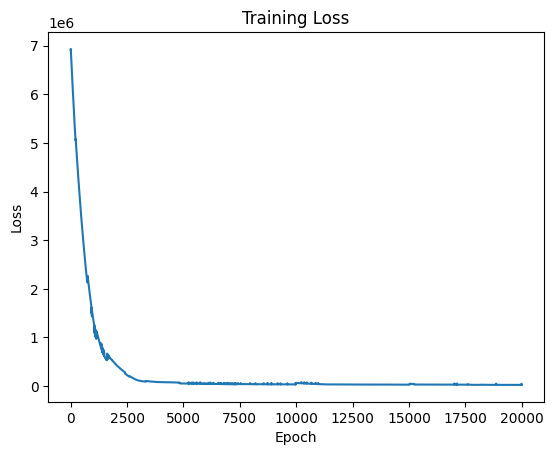

In [56]:
_ = classModelRandom.train(X_train, Y_train, n_epochs=5000, batch_size=256, lr=1e-5, plot=True)

In [57]:
print("Random model: ", np.mean(classModelRandom.evaluateEncoded(X_test, Y_test)))

Evaluating model: random model
Random model:  0.0


In [62]:
classModelRandom.resetWeights()

n_epochs_values = [100]
batch_size_values = [256]
learning_rate_values = [1e-5]

classModelRandom.gridSearch(X_train, Y_train, X_test, Y_test, n_epochs_values, batch_size_values, learning_rate_values, averageCount=5)

100%|██████████| 100/100 [00:08<00:00, 12.43it/s]


   n_epochs  batch_size  learning_rate  accuracy_mean  accuracy_std
0       100         256        0.00001            0.0           0.0


# Showing some pecularities

## A trained model performing worse than the original model

Often when a perfect rasp model is trained further it causses the model to become significantly worse

Data splits
(765, 6) (135, 6) (100, 6)
(765, 6) (135, 6) (100, 6)
765 135 100
Evaluating model: Original weights
1.0
Evaluating model: Non-encoded original weights
1.0


  3%|▎         | 142/5000 [00:28<16:02,  5.05it/s]

Stopped training after 142 epochs by early stopping


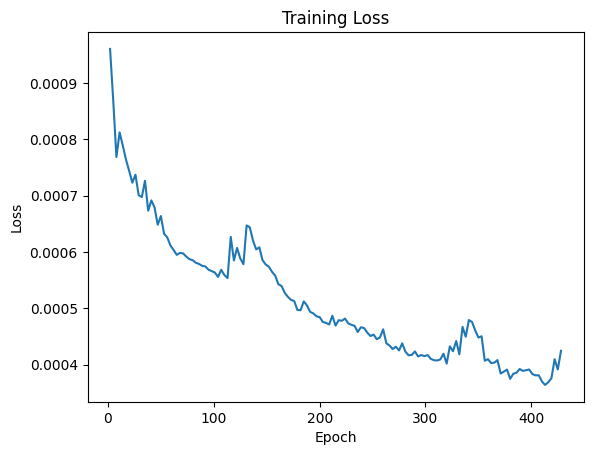

Evaluating model: Trained weights
0.68
Evaluating model: Non-encoded trained weights
0.68


In [290]:
maxLength = 5
name = "sort"

np.random.seed(666)
model = generateModel(name, maxLength)

data = generateData(name, maxLength, 1000)
split = int(len(data) * 0.90)
data_train, data_test = data[:split], data[split:]
split = int(len(data_train) * 0.85)
data_train, data_val = data_train[:split], data_train[split:]
X, Y = encodeAndPadData(data, model.raspFunction, model.inputs, maxLength)

#Split data
split = int(X.shape[0] * 0.90)
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]

split = int(X_train.shape[0] * 0.85)
X_train, X_val = X_train[:split], X_train[split:]
Y_train, Y_val = Y_train[:split], Y_train[split:]

#Data splits
print("Data splits")
print(X_train.shape, X_val.shape, X_test.shape)
print(Y_train.shape, Y_val.shape, Y_test.shape)
print(len(data_train), len(data_val), len(data_test))

#Training model
print(model.evaluateEncoded(X_test, Y_test, "Original weights", outputArray=False))
print(model.evaluateModel(data_test, "Non-encoded original weights", outputArray=False))
model.train(X_train, Y_train, 5000, 256, 1e-4, True, X_val=X_val, Y_val=Y_val, valCount=5)
print(model.evaluateEncoded(X_test, Y_test, "Trained weights", outputArray=False))
print(model.evaluateModel(data_test, "Non-encoded trained weights", outputArray=False))


## Assymetry in the evaluation results for encoded and non encoded evaluation

This happens due to the rasp model and the training model not outputting the same results

Data splits
(765, 6) (135, 6) (100, 6)
(765, 6) (135, 6) (100, 6)
765 135 100
Evaluating model: Random weights
0.04
Evaluating model: Non-encoded random weights
0.04


 34%|███▍      | 515/1500 [01:46<03:23,  4.84it/s]

Stopped training after 515 epochs by early stopping


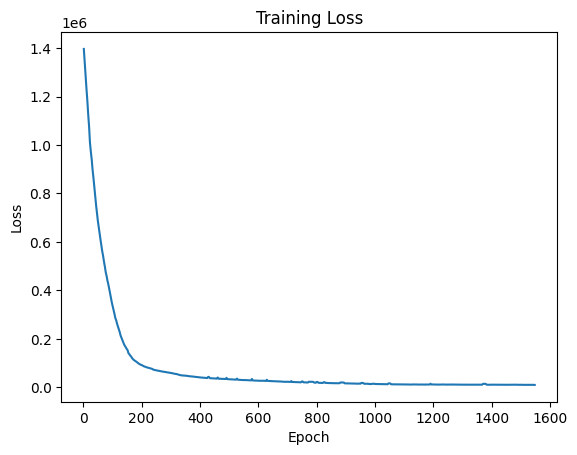

Evaluating model: Trained weights
0.04
Evaluating model: Non-encoded trained weights
0.015


In [310]:
maxLength = 5
name = "sort"

np.random.seed(42)
model = generateModel(name, maxLength)

data = generateData(name, maxLength, 1000)
split = int(len(data) * 0.90)
data_train, data_test = data[:split], data[split:]
split = int(len(data_train) * 0.85)
data_train, data_val = data_train[:split], data_train[split:]
X, Y = encodeAndPadData(data, model.raspFunction, model.inputs, maxLength)

#Split data
split = int(X.shape[0] * 0.90)
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]

split = int(X_train.shape[0] * 0.85)
X_train, X_val = X_train[:split], X_train[split:]
Y_train, Y_val = Y_train[:split], Y_train[split:]

#Data splits
print("Data splits")
print(X_train.shape, X_val.shape, X_test.shape)
print(Y_train.shape, Y_val.shape, Y_test.shape)
print(len(data_train), len(data_val), len(data_test))

#Setting random weights
model.setRandomWeights()

#Training model
print(model.evaluateEncoded(X_test, Y_test, "Random weights", outputArray=False))
print(model.evaluateModel(data_test, "Non-encoded random weights", outputArray=False))
model.train(X_train, Y_train, 1500, 256, 1e-4, True, X_val=X_val, Y_val=Y_val, valCount=5)
encodedResults = model.evaluateEncoded(X, Y, "Trained weights", outputArray=True)
print(np.mean(encodedResults))
nonEncodedResults = model.evaluateModel(data, "Non-encoded trained weights", outputArray=True)
print(np.mean(nonEncodedResults))

In [318]:
print("A few indexes where encoded (aka training ouput) was correct but not non-encoded (aka rasp model output) and vice versa")
print(np.where(encodedResults>nonEncodedResults)[0][:5])
print(np.where(nonEncodedResults>encodedResults)[0][:5])

print("\nEncoding map for input and output for clarity")
print(model.model.input_encoder.encoding_map)
print(model.model.output_encoder.encoding_map)

print("\nEncoded correct non-encoded incorrect")
target = 102
print("Non-encoded data [in,out]:", data[target])
print("Rasp model output:", model.apply(data[target][0]))
print("Encoded data [in,out]: [", X[target], Y[target],"]")
print("Training output:", model.forward(jnp.array(X[target].reshape(1,-1))).unembedded_output.argmax(axis=-1)[0]) 
print("NOTE Only index 1-2 are considered as the rest is BOS or padding and is masked out")   

print("\nEncoded incorrect non-encoded correct")
target = 85
print("Non-encoded data [in,out]:", data[target])
print("Rasp model output:", model.apply(data[target][0]))
print("Encoded data [in,out]: [", X[target], Y[target],"]")
print("Training output:", model.forward(jnp.array(X[target].reshape(1,-1))).unembedded_output.argmax(axis=-1)[0]) 
print("NOTE Only index 1-2 are considered as the rest is BOS or padding and is masked out")    

A few indexes where encoded (aka training ouput) was correct but not non-encoded (aka rasp model output) and vice versa
[ 25  43  92 102 111]
[ 85 251 333 357 398]

Encoding map for input and output for clarity
{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 'BOS': 6, 'compiler_pad': 7}
{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}

Encoded correct non-encoded incorrect
Non-encoded data [in,out]: (['BOS', np.int64(1), np.int64(5)], ['BOS', np.int64(1), np.int64(5)])
Rasp model output: ['BOS', 4, 5]
Encoded data [in,out]: [ [6 0 4 7 7 7] [0 0 4 0 0 0] ]
Training output: [0 0 4 0 1 0]
NOTE Only index 1-2 are considered as the rest is BOS or padding and is masked out

Encoded incorrect non-encoded correct
Non-encoded data [in,out]: (['BOS', np.int64(5), np.int64(1)], ['BOS', np.int64(1), np.int64(5)])
Rasp model output: ['BOS', 1, 5]
Encoded data [in,out]: [ [6 4 0 7 7 7] [0 0 4 0 0 0] ]
Training output: [0 0 0 0 1 0]
NOTE Only index 1-2 are considered as the rest is BOS or padding and is masked out


In [ ]:
for i in range(3):
    print(data[i])
    print(model.apply(data[i][0]))
    print(X[i],Y[i],"\n#######")
"""offset=90
print(temp3[offset:offset+15])
print(temp4[offset:offset+15])"""
print("Encoded true unencoded false")
target = 16 #Encoded true unencoded false
#print(temp3[target], temp4[target])
print(data[target])
print(model.apply(data[target][0]))
print(X[target],Y[target])
#print(X[target])
#print(model.forward(jnp.array(X[target])))      
print(model.forward(jnp.array(X[target])).unembedded_output.argmax(axis=-1)[0])      
#My training data does not seem to have the same structure as his training data. The shapes are the same but when indexing his you get (1, len) not (len,)
#Might be due to creating a jnp array from numpy encoded variables instead of raw variables
target = 177#Opposite
#print(temp3[target], temp4[target])
print("Encoded false unencoded true")
print(data[target])
print(model.apply(data[target][0]))
print(X[target],Y[target])
#print(model.forward(X[target]))
print(model.forward(X[target:target+1]).unembedded_output.argmax(axis=-1)[0])  

## Some weights causes failure

I believ the bug comes from the logits given by the forward function often being nan with some models. I have found in some cases that not all the values are nan and some are ok although this seems to be rare. My best guess is that this is caused by over or underflow somewhere in the model.

100%|██████████| 10/10 [00:01<00:00,  9.23it/s]


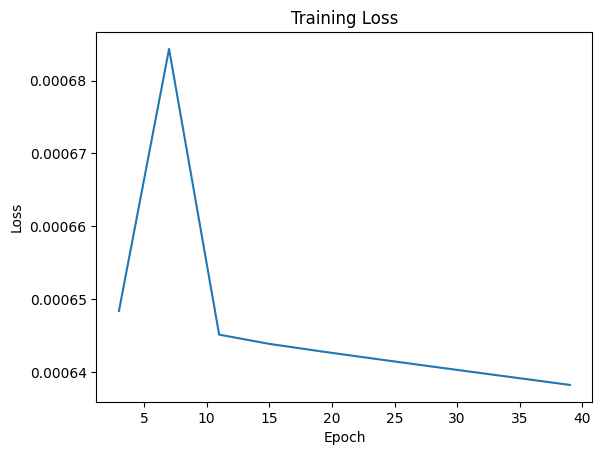

  0%|          | 0/10 [00:00<?, ?it/s]

Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.
Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.


  0%|          | 0/10 [00:00<?, ?it/s]


FloatingPointError: invalid value (nan) encountered in jit(update). Because jax_config.debug_nans.value and/or config.jax_debug_infs is set, the de-optimized function (i.e., the function as if the `jit` decorator were removed) was called in an attempt to get a more precise error message. However, the de-optimized function did not produce invalid values during its execution. This behavior can result from `jit` optimizations causing the invalid value to be produced. It may also arise from having nan/inf constants as outputs, like `jax.jit(lambda ...: jax.numpy.nan)(...)`. 

It may be possible to avoid the invalid value by removing the `jit` decorator, at the cost of losing optimizations. 

If you see this error, consider opening a bug report at https://github.com/google/jax.

In [299]:
maxLength = 5
name = "reverse"

np.random.seed(666)
model = generateModel(name, maxLength)

X, Y = generateAndEncodeData(name, maxLength, 1000)

model.train(X,Y, 10, 256, 1e-04, True)

model.setRandomWeights()
model.train(X,Y, 10, 256, 1e-04, True)